# Import library

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Dữ liệu từ 1999 - 2022

Xây dựng mô hình dự đoán tỷ lệ tử vong thông qua các yếu tố trong bộ dự liệu từ năm 1999 - 2022.

## Chuẩn bị dữ liệu

In [36]:
data = pd.read_csv("DATA/infant_mortality_data_1999_2022_cleaned.csv")

In [37]:
print("Data size:", data.shape)
data.dtypes

Data size: (22666, 9)


Cause of death             object
Age of mother              object
Mother's education         object
Birth weight               object
Age of infant at death     object
Deaths                      int64
Births                      int64
Death rate per 1000       float64
Year                        int64
dtype: object

In [38]:
data.head()

,Cause of death,Age of mother,Mother's education,Birth weight,Age of infant at death,Deaths,Births,Death rate per 1000,Year
0,Certain infectious and parasitic diseases,15-19,High School Incomplete,500 - 999,672 - 8736,14,1927,7.265179,1999
1,Certain infectious and parasitic diseases,15-19,High School Incomplete,2500 - 2999,672 - 8736,11,31891,0.344925,1999
2,Certain infectious and parasitic diseases,15-19,High School Incomplete,3000 - 3499,672 - 8736,10,31891,0.313568,1999
3,Certain infectious and parasitic diseases,20-24,High School Incomplete,500 - 999,672 - 8736,15,1179,12.722646,1999
4,Certain infectious and parasitic diseases,20-24,High School Graduate,500 - 999,672 - 8736,17,2490,6.827309,1999


In [39]:
features = data.drop(columns=['Death rate per 1000'])
target = data['Death rate per 1000']
features = pd.get_dummies(features, columns=['Cause of death', "Age of mother", "Mother's education", "Birth weight", "Age of infant at death", "Year"])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Kmeans

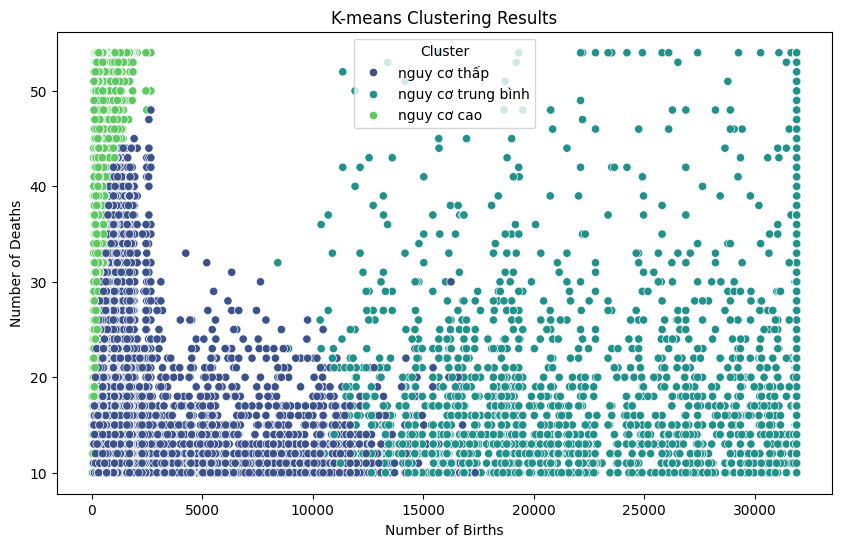

In [41]:
features = data[['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death', 'Deaths', 'Births', 'Death rate per 1000']]

# Chuyển đổi các cột phân loại thành các biến giả (one-hot encoding)
categorical_features = ['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death']
numeric_features = ['Deaths', 'Births', 'Death rate per 1000']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Áp dụng tiền xử lý dữ liệu
scaled_features = preprocessor.fit_transform(features)

# Phân tích phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Number of Births')
plt.ylabel('Number of Deaths')
plt.legend(title='Cluster')
plt.show()

## Model

In [42]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Support Vector Machine": SVR(C=1, epsilon=0.1, kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

In [43]:
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    
    # Store the results
    results[model_name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Predictions": y_pred
    }

## Biểu diễn kết quả

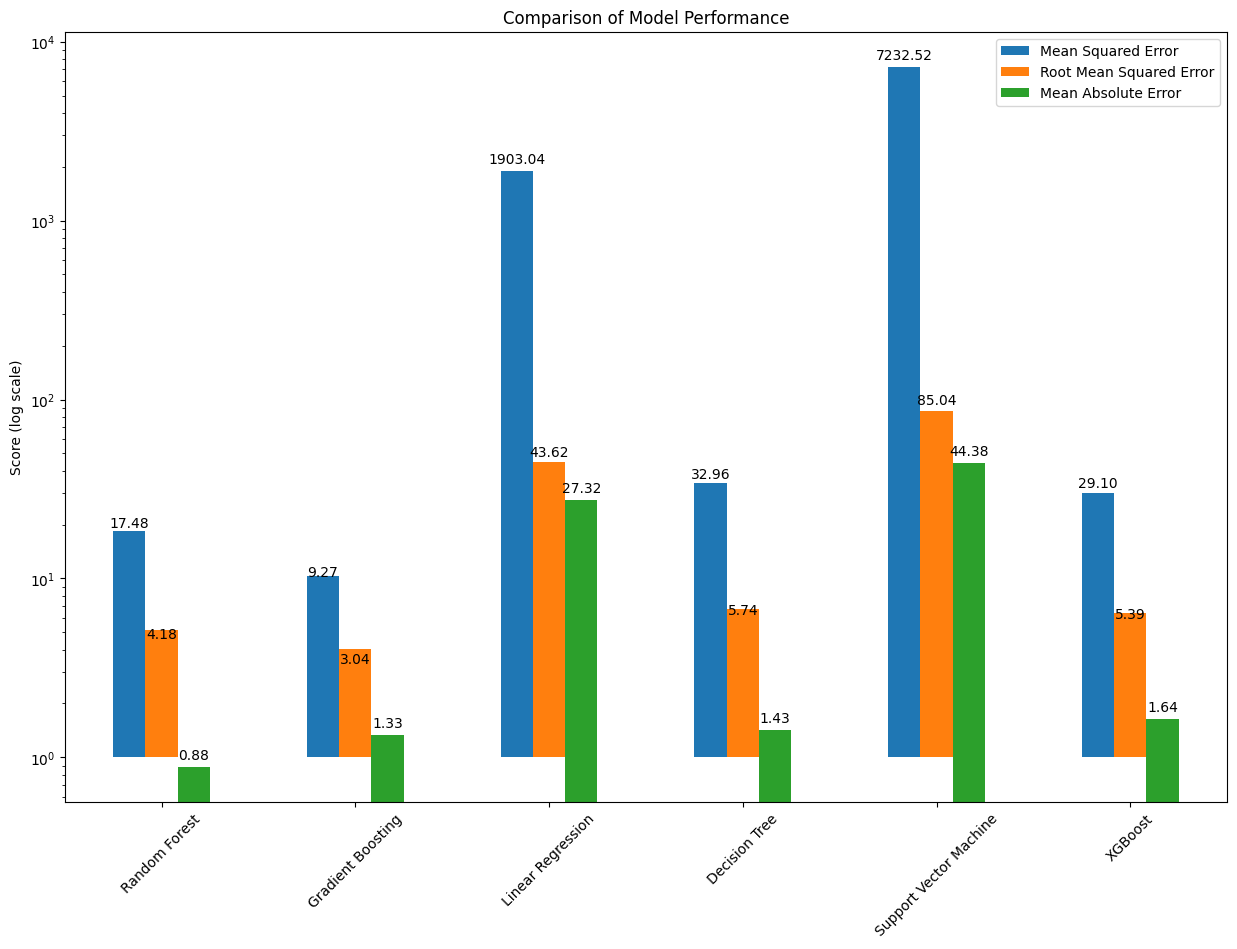

In [44]:
comparison_df = pd.DataFrame(results).T

# Plot the comparison of models' performance with log scale to avoid column values being too skewed
ax = comparison_df[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']].plot(kind='bar', figsize=(15, 10), log=True)
plt.title('Comparison of Model Performance')
plt.ylabel('Score (log scale)')
plt.xticks(rotation=45)
plt.legend(loc='best')

# Add numbers on top of each bar with a higher position to avoid overlapping with bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1), ha='center')

plt.show()

# Dữ liệu 2017 - 2022

Xây dụng mô hình dự đoán tỷ lệ tử vong với dữ liệu từ 2017 - 2022, đặc biệt có thêm các trường dữ liệu như: 

## Prepare data

In [45]:
data = pd.read_csv('DATA/infant_mortality_data_2017_2022_cleaned.csv')

In [46]:
print("Data size:", data.shape)
data.dtypes

Data size: (1443, 9)


Cause of death                 object
NICU Admission                  int64
Antibiotics for Mother          int64
Mother's Pre-pregnancy BMI      int64
Infant birth weight           float64
Deaths                          int64
Births                          int64
Death rate per 1000           float64
Year                            int64
dtype: object

In [47]:
data.head()

,Cause of death,NICU Admission,Antibiotics for Mother,Mother's Pre-pregnancy BMI,Infant birth weight,Deaths,Births,Death rate per 1000,Year
0,Other causes,1,1,2,624.5,12,726,16.56,2017
1,Other causes,1,0,1,624.5,13,1254,10.40,2017
2,Other causes,1,0,1,874.5,10,1701,5.88,2017
3,Other causes,1,0,2,624.5,12,994,12.08,2017
4,Incompetent cervix,0,1,1,249.5,12,270,45.00,2017


In [48]:
features = data.drop(columns=['Death rate per 1000'])
target = data['Death rate per 1000']
features = pd.get_dummies(features, columns=['Cause of death'])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Kmeans

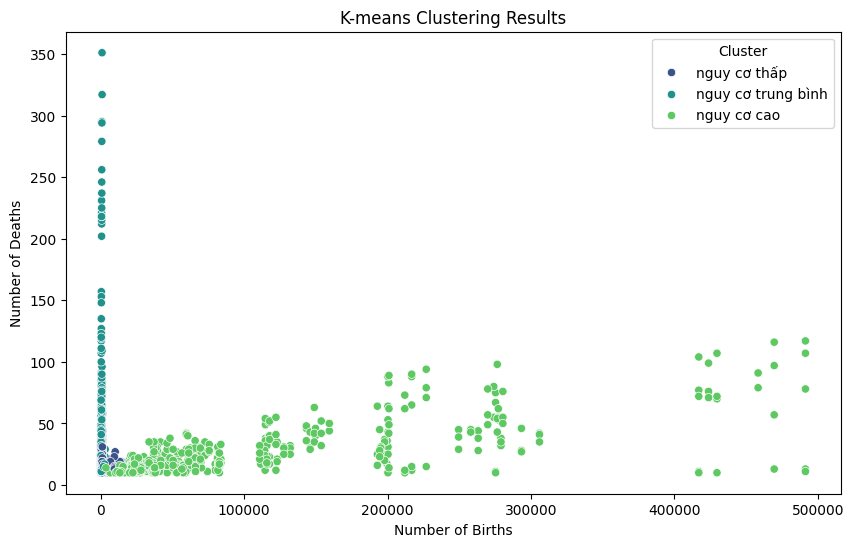

In [50]:
categorical_features = ['Cause of death']
numeric_features = [ 'NICU Admission', 'Antibiotics for Mother', "Mother's Pre-pregnancy BMI", 'Infant birth weight', 'Deaths', 'Births']

# Preprocessor for scaling numeric features and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Select features
features = data.drop(columns=['Death rate per 1000'])

# Apply the preprocessor to the features
scaled_features = preprocessor.fit_transform(features)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

# Map cluster labels to descriptive names
cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

# Plot the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Number of Births')
plt.ylabel('Number of Deaths')
plt.legend(title='Cluster')
plt.show()

## Model

In [51]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Support Vector Machine": SVR(C=1, epsilon=0.1, kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

In [52]:
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store the results
    results[model_name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Predictions": y_pred
    }

## Biểu diễn kết quả

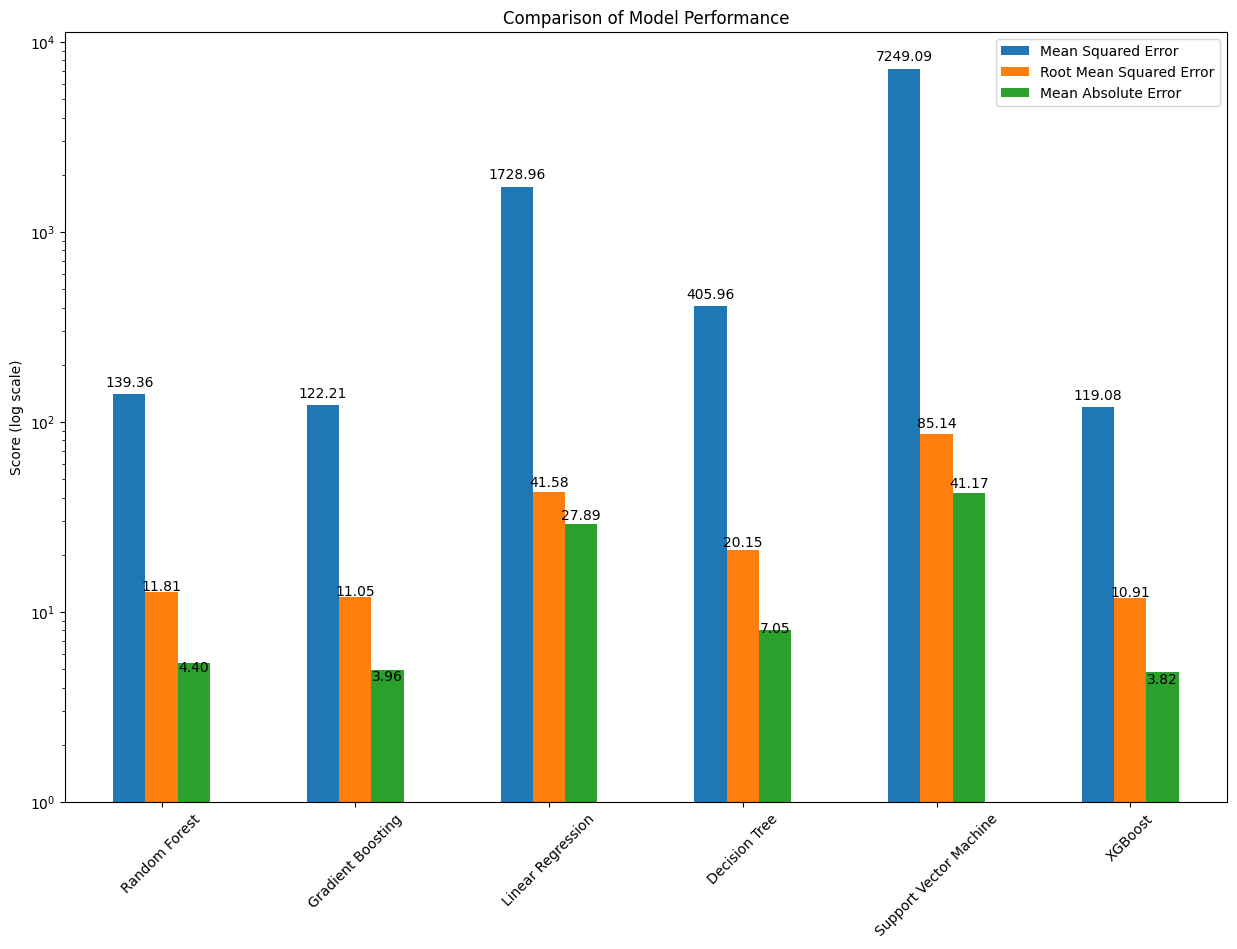

In [53]:
comparison_df = pd.DataFrame(results).T

# Plot the comparison of models' performance with log scale to avoid column values being too skewed
ax = comparison_df[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']].plot(kind='bar', figsize=(15, 10), log=True)
plt.title('Comparison of Model Performance')
plt.ylabel('Score (log scale)')
plt.xticks(rotation=45)
plt.legend(loc='best')

# Add numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1), ha='center')
plt.show()